# Power Generation in the UK 

## Data Prep

Analyze daily power generation by source.

In [4]:
# Insert Data Source Here
from domino.data_sources import DataSourceClient

# instantiate a client and fetch the datasource instance
object_store = DataSourceClient().get_datasource("domino-power-generation-workshop")

# list objects available in the datasource
objects = object_store.list_objects()

## get content as binary
# content = object_store.get("key")

## download content to file
# object_store.download_file("key", "./path/to/local/file")

## Download content to file object
# f = io.BytesIO()
# object_store.download_fileobj("key", f)

In [30]:
from io import StringIO
import pandas as pd

s = str(object_store.get("PowerGenerationData_Summer_2022.csv"),'utf-8')
data = StringIO(s) 

df = pd.read_csv(data, parse_dates=['datetime'])
df.head()

,HDF,datetime,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM
0,FUELHH,2022-06-01 00:00:00,16925,0,0,5139,1445,0,257,2,155,8,178,0,0,1718,0
1,FUELHH,2022-06-01 00:30:00,16539,0,0,5140,1432,0,234,3,149,0,200,0,0,1701,0
2,FUELHH,2022-06-01 01:00:00,17381,0,0,5142,1566,0,201,0,124,0,170,0,0,1698,0
3,FUELHH,2022-06-01 01:30:00,17415,0,0,5137,1491,0,197,0,139,0,168,0,0,1720,0
4,FUELHH,2022-06-01 02:00:00,17457,0,0,5137,1337,0,196,0,152,0,188,0,0,1734,0


## Vizualize the static dataset using matplotlib

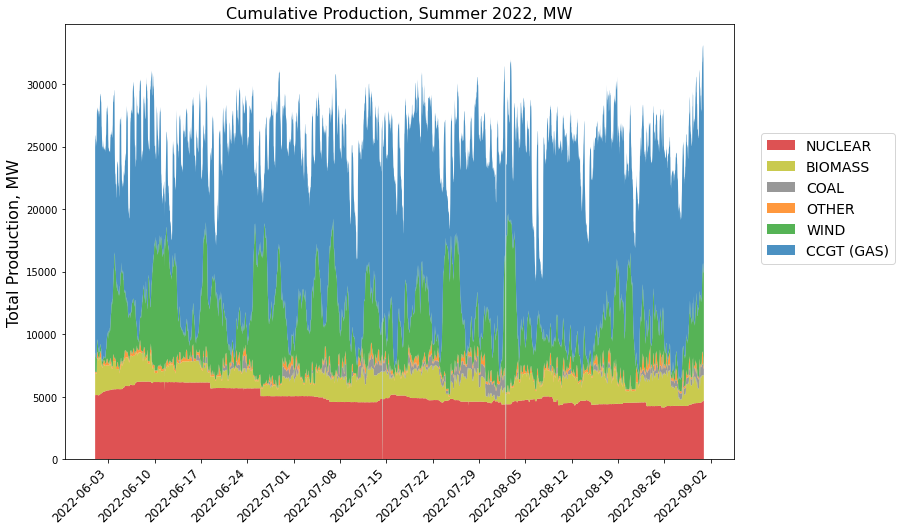

In [48]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create total output feature: sum of all fuel sources.
df['TOTAL'] = df.sum(axis=1, numeric_only=True)

# Select CCGT, Wind, Nuclear, Biomass and Coal & create "Other" column
plot_cols = ['CCGT', 'WIND', 'NUCLEAR','BIOMASS', 'COAL', 'TOTAL']

df_plot = df[plot_cols].copy()

df_plot['OTHER'] = df_plot['TOTAL'] - df_plot[['CCGT', 'WIND', 'NUCLEAR','BIOMASS', 'COAL']].sum(axis=1, numeric_only=True)

# Plot Cumulative production up to prediction point
x = df.datetime
y = [df.NUCLEAR, df.BIOMASS, df.COAL, df.OTHER, df.WIND, df.CCGT,]

fig, ax = plt.subplots(1,1, figsize=(12,8))

colors = ['tab:red','tab:olive', 'tab:gray','tab:orange','tab:green','tab:blue']

ax.stackplot(x,y,
             labels=['NUCLEAR', 'BIOMASS', 'COAL', 'OTHER', 'WIND', 'CCGT (GAS)'],
             colors=colors,
             alpha=0.8)

# Format the stack plot
ax.legend(bbox_to_anchor=(1.25, 0.6), loc='right', fontsize=14)
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=45, ha='right', fontsize=12)
ax.set_ylabel('Total Production, MW', fontsize=16)
ax.set_title('Cumulative Production, Summer 2022, MW', fontsize=16)

# Save the figure as an image to the Domino File System
fig.savefig('Cumulative Production.png', bbox_inches="tight")

plt.show()

## Extract Daily Peak Production across all fuel types as a Feature

From the initial raw data, we can 

In [49]:
# Read in 30 minute data
s = str(object_store.get("PowerGenerationData_Summer_2022.csv"),'utf-8')
data = StringIO(s) 
daily_peak_df = pd.read_csv(data, parse_dates=['datetime'])

# Set the index to the timestamp, and create a column of TOTAL demand by row
daily_peak_df = daily_peak_df.set_index('datetime')
daily_peak_df = daily_peak_df.drop(['HDF'], axis=1)
daily_peak_df['TOTAL'] = daily_peak_df.sum(axis=1)

# Group 30 minute data by day, grab the index of the 30-minute interval when the daily demand peaks
idx = daily_peak_df.groupby(pd.Grouper(freq='D'))['TOTAL'].transform(max) == daily_peak_df['TOTAL']

# Verify there are no duplicate Maximum values in a single day in the dataset
print(daily_peak_df[idx].shape)

# Print a table with the daily Maximum values, and time when demand peaked
daily_peak_df = daily_peak_df[idx]

daily_peak_df.head()

(92, 16)


,CCGT,OIL,COAL,NUCLEAR,WIND,PS,NPSHYD,OCGT,OTHER,INTFR,INTIRL,INTNED,INTEW,BIOMASS,INTEM,TOTAL
datetime,,,,,,,,,,,,,,,,
2022-06-01 19:00:00,20014,0,0,5219,530,1404,537,2,549,0,0,104,0,2931,0,31290
2022-06-02 18:30:00,18479,0,0,5513,1573,964,565,130,527,0,0,0,0,2014,0,29765
2022-06-03 21:00:00,13843,0,0,5602,7607,0,344,0,228,0,64,0,0,2244,0,29932
2022-06-04 20:00:00,12458,0,0,5613,7012,292,486,1,463,0,240,0,0,1681,0,28246
2022-06-05 18:00:00,15276,0,0,5865,4318,574,505,0,523,418,0,102,0,2274,0,29855


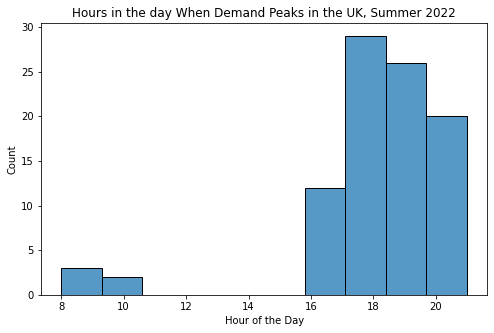

In [68]:
plt.figure(figsize=(8,5))
plt.title('Hours in the day When Demand Peaks in the UK, Summer 2022')
plt.xlabel('Hour of the Day')
sns.histplot(daily_peak_df.index.hour, stat='count', bins=10)
plt.savefig('Peak Demand Hours.png', bbox_inches="tight")
plt.show()

In [55]:
import os
path = str('/domino/datasets/local/{}/Daily_Peak_Production_Summer_2022.csv'.format(os.environ.get('DOMINO_PROJECT_NAME')))
daily_peak_df.to_csv(path, index = False)

OSError: Cannot save file into a non-existent directory: '/domino/datasets/local/PowerGenerationWorkshop'